# Import module, packages

In [54]:
!pip install iPython_SQL

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.edge.service import Service
import pandas as pd
import os
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import csv, sqlite3

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



# 1. Data Collection, Understanding, Preparation

### Scrap Data From BatDongSan.Com

In [169]:
def scrapping():
    service = Service('msedgedriver.exe')
    driver = webdriver.Edge(service=service)
    
    for page in range(1,1800):
        try:
            # Initial Fields
            price_list = list()
            location_list = list()
            area_list = list()
            priceByArea_list = list()
            bedroom_list = list()
            bathroom_list = list()
            
            url = f'https://batdongsan.com.vn/ban-nha-dat/5pn/p{page}?rs=4,3,2,1'
            driver.get(url)
            
            time.sleep(4)
            
            try:
                close_button = driver.find_element(By.CLASS_NAME, 'close') 
                print("Close button found!")
                close_button.click()
                print("Close button clicked!")
                time.sleep(1)  
                modal = driver.find_element(By.ID, 'dialogPopup')
                if not modal.is_displayed():
                    print("Modal closed successfully!")
                else:
                    print("Modal is still visible.")
            except :
                print("Close button not found!")
            
            time.sleep(2)
    
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(1) 
        
    
            
            locations = driver.find_elements(By.CLASS_NAME, 're__card-location')
            for location in locations:
                spans = location.find_elements(By.TAG_NAME, 'span')
                if location.find_elements(By.CLASS_NAME, 're__icon-location--sm') and spans:
                    location_list.append(spans[0].text)
                elif len(spans) > 1:
                    location_list.append(spans[1].text) 
                else:
                    location_list.append('Unknown')
        
            card_configs = driver.find_elements(By.CSS_SELECTOR, '.re__card-config.js__card-config')
            for card in card_configs:
                result = card.text.split('\n')
                price_list.append(result[0])
                
                area_list.append(result[2])
                
                priceByArea_list.append(result[4] if len(result) > 4 else 'Null')
                
                bedroom_list.append(result[6] if len(result) > 6 else 'Null')
                bathroom_list.append(result[8] if len(result) > 8 else 'Null')
            
            if 'Vay mua nhà' in price_list:
                price_list.remove('Vay mua nhà')
        
            # Kiểm tra số lượng phần tử đã cào được
            print(f'Price: {len(price_list)}')
            print(f'Location: {len(location_list)}')
            print(f'Area: {len(area_list)}')
            print(f'Price/m2: {len(priceByArea_list)}')
            print(f'BedRoom: {len(bedroom_list)}')
            print(f'Toilet: {len(bathroom_list)}')
            
            
            data = {'Page': [page for i in range(len(price_list))],'Price': price_list, 'Location': location_list, 'Area': area_list, 'Price/m2': priceByArea_list, 
                   'BedRoom':bedroom_list, 'Toilet': bathroom_list}
            df = pd.DataFrame(data)
            if os.path.exists('HouseData.csv'):
                df.to_csv('HouseData.csv', mode='a', header=False, index=False)
            else:
                df.to_csv('HouseData.csv', mode='w', header=True, index=False)
            print(f'Page {page} is done.')
        except:
            print(f'Error with page{page}')
    
    driver.quit()
    


### Data Cleaning

In [2]:
df = pd.read_csv('HouseData.csv')
df

,Page,Price,Location,Area,Price/m2,BedRoom,Toilet
0,1,8 tỷ,"Văn Giang, Hưng Yên",72 m²,"111,11 tr/m²",5,4
1,1,"7,4 tỷ","Văn Giang, Hưng Yên",63 m²,"117,46 tr/m²",8,4
2,1,"11,9 tỷ","Văn Giang, Hưng Yên",112 m²,"106,25 tr/m²",6,6
3,1,Giá thỏa thuận,"Đông Anh, Hà Nội",75 m²,8,7,Null
4,1,60 tỷ,"Quận 2, Hồ Chí Minh",300 m²,200 tr/m²,5,5
...,...,...,...,...,...,...,...
39899,2000,51 tỷ,"Hạ Long, Quảng Ninh",360 m²,"141,67 tr/m²",7,5
39900,2000,Giá thỏa thuận,"Quận 3, Hồ Chí Minh",124 m²,3,2,Null
39901,2000,"25,5 tỷ","Đống Đa, Hà Nội",86 m²,"296,51 tr/m²",4,7
39902,2000,"10,12 tỷ","Quận 12, Hồ Chí Minh",115 m²,88 tr/m²,2,2


In [3]:
df['Price'] = df['Price'].apply(lambda x: x if 'Giá thỏa thuận' not in x else np.nan)
df['Price/m2'] = df['Price/m2'].apply(lambda x: x if ('Null' not in x) and ('tr/m²' in x) else np.nan)
df['BedRoom'] = df['BedRoom'].apply(lambda x: x if 'Null' not in x else np.nan)
df['Toilet'] = df['Toilet'].apply(lambda x: x if 'Null' not in x else np.nan)

In [4]:
df.isnull().sum()

Page           0
Price       4030
Location       0
Area           0
Price/m2    4111
BedRoom      247
Toilet      7210
dtype: int64

In [5]:
df.dropna(inplace=True, axis=0)
df.reset_index(inplace=True, drop=True)
df.isnull().sum()

Page        0
Price       0
Location    0
Area        0
Price/m2    0
BedRoom     0
Toilet      0
dtype: int64

In [6]:
def convert_to_float(x):
    x = x.replace('.', '')
    x = x.replace(',', '.')
    return float(x)

def convert_unit(x):
    num = x.split(' ')[0].strip()
    num = convert_to_float(num)
    if 'tỷ' in x:
        return num * (10**9)
    elif 'triệu' in x:
        return num * (10**6)
    elif 'nghìn' in x:
        return num * (10**3)
    
df.Area = df.Area.apply(lambda x: x.split(' ')[0].strip())
df.Area = df.Area.apply(convert_to_float)

df['Price/m2'] = df['Price/m2'].apply(lambda x: x.split(' ')[0].strip())
df['Price/m2'] = df['Price/m2'].apply(convert_to_float)
df['Price/m2'] = df['Price/m2'].apply(lambda x: x * 1000000) # Chuyển về đơn vị triệu

df.Price = df.Price.apply(convert_unit)

df.BedRoom = df.BedRoom.apply(convert_to_float)

df.Toilet = df.Toilet.apply(convert_to_float)

df.drop(columns=['Page'], inplace = True)

#### Data Preparation

In [7]:
# Thêm thông tin cho datset

df['Province'] = df['Location'].apply(lambda x: x.split(',')[1].strip())
df['AreaSegment'] = pd.cut(x=df['Area'], bins=[0, 30, 50, 100, 150, 250, 350, 500, 999999], 
                           labels=["Dưới 30m²", "30m² - 50m²", "50m² - 100m²", "100m² - 150m²", "150m² - 250m²", "250m² - 350m²", "350m² - 500m²", "Trên 500m²"])
df['PriceSegment'] = pd.cut(x=df['Price'], bins=[0, 500*(10**6), 1*(10**9), 5*(10**9), 10*(10**9), 20*(10**9), 40*(10**9), 60*(10**9), 100*(10**9), 1000*(10**9) ], 
                           labels=["Dưới 500 triệu", "500 triệu - 1 tỷ", "1 tỷ - 5 tỷ", "5 tỷ - 10 tỷ", "10 tỷ - 20 tỷ", "20 tỷ - 40 tỷ", "40 tỷ - 60 tỷ", "60 tỷ - 100 tỷ", "100 tỷ - 1000 tỷ"])

tourist_area = ['Phú Quốc', 'Nha Trang', 'Đà Lạt', 'Đà Nẵng']
pattern = '|'.join(tourist_area)
df_tourism = df.loc[df.Location.str.contains(pattern)]
df_tourism.reset_index(drop=True, inplace=True)

#### Data After Step Preparing

In [8]:
df_tourism = df_tourism[['Province', 'Location', 'Area', 'AreaSegment', 'Price/m2',	'BedRoom', 'Toilet', 'Price', 'PriceSegment']]
df_tourism

,Province,Location,Area,AreaSegment,Price/m2,BedRoom,Toilet,Price,PriceSegment
0,Đà Nẵng,"Sơn Trà, Đà Nẵng",108.0,100m² - 150m²,150000000.0,5.0,5.0,1.620000e+10,10 tỷ - 20 tỷ
1,Đà Nẵng,"Sơn Trà, Đà Nẵng",120.0,100m² - 150m²,126670000.0,8.0,10.0,1.520000e+10,10 tỷ - 20 tỷ
2,Đà Nẵng,"Sơn Trà, Đà Nẵng",108.0,100m² - 150m²,142000000.0,5.0,6.0,1.534000e+10,10 tỷ - 20 tỷ
3,Đà Nẵng,"Cẩm Lệ, Đà Nẵng",100.0,50m² - 100m²,59000000.0,3.0,3.0,5.900000e+09,5 tỷ - 10 tỷ
4,Đà Nẵng,"Sơn Trà, Đà Nẵng",108.0,100m² - 150m²,140740000.0,10.0,12.0,1.520000e+10,10 tỷ - 20 tỷ
...,...,...,...,...,...,...,...,...,...
1811,Lâm Đồng,"Đà Lạt, Lâm Đồng",157.0,150m² - 250m²,55410000.0,4.0,4.0,8.700000e+09,5 tỷ - 10 tỷ
1812,Khánh Hòa,"Nha Trang, Khánh Hòa",52.9,50m² - 100m²,46310000.0,2.0,2.0,2.450000e+09,1 tỷ - 5 tỷ
1813,Đà Nẵng,"Hải Châu, Đà Nẵng",75.0,50m² - 100m²,70670000.0,3.0,2.0,5.300000e+09,5 tỷ - 10 tỷ
1814,Đà Nẵng,"Ngũ Hành Sơn, Đà Nẵng",155.0,150m² - 250m²,387100000.0,40.0,40.0,6.000000e+10,40 tỷ - 60 tỷ


In [9]:
con = sqlite3.connect("HouseData.db")
cur = con.cursor()

In [10]:
%load_ext sql

In [11]:
%sql sqlite:///HouseData.db

In [12]:
df_tourism.to_sql('KhuDuLich', con, if_exists='replace', index=False)

1816

In [13]:
%%sql
SELECT *
FROM KhuDuLich
WHERE [Price/m2] >= 100000000;


 * sqlite:///HouseData.db
Done.


Province,Location,Area,AreaSegment,Price/m2,BedRoom,Toilet,Price,PriceSegment
Đà Nẵng,"Sơn Trà, Đà Nẵng",108.0,100m² - 150m²,150000000.0,5.0,5.0,16200000000.0,10 tỷ - 20 tỷ
Đà Nẵng,"Sơn Trà, Đà Nẵng",120.0,100m² - 150m²,126670000.0,8.0,10.0,15200000000.0,10 tỷ - 20 tỷ
Đà Nẵng,"Sơn Trà, Đà Nẵng",108.0,100m² - 150m²,142000000.0,5.0,6.0,15340000000.0,10 tỷ - 20 tỷ
Đà Nẵng,"Sơn Trà, Đà Nẵng",108.0,100m² - 150m²,140740000.0,10.0,12.0,15200000000.0,10 tỷ - 20 tỷ
Đà Nẵng,"Sơn Trà, Đà Nẵng",108.0,100m² - 150m²,250000000.0,4.0,5.0,27000000000.0,20 tỷ - 40 tỷ
Lâm Đồng,"Đà Lạt, Lâm Đồng",357.0,350m² - 500m²,217860000.0,3.0,3.0,77780000000.0,60 tỷ - 100 tỷ
Đà Nẵng,"Ngũ Hành Sơn, Đà Nẵng",145.0,100m² - 150m²,310350000.0,24.0,26.0,45000000000.0,40 tỷ - 60 tỷ
Đà Nẵng,"Hải Châu, Đà Nẵng",145.0,100m² - 150m²,189660000.0,17.0,17.0,27500000000.0,20 tỷ - 40 tỷ
Khánh Hòa,"Nha Trang, Khánh Hòa",65.5,50m² - 100m²,351140000.0,4.0,5.0,23000000000.0,20 tỷ - 40 tỷ
Đà Nẵng,"Hải Châu, Đà Nẵng",145.0,100m² - 150m²,172410000.0,17.0,17.0,25000000000.0,20 tỷ - 40 tỷ


In [14]:
con.close()

### Phân tích giá nhà tại các khu du lịch

1.	Giá trị trung bình (mean).
2.	Trung vị (median).
3.	Độ lệch chuẩn (std).
4.	Giá trị nhỏ nhất (min).
5.	Giá trị lớn nhất (max).
6.	Phân vị thứ 25% (25% quantile).
7.	Phân vị thứ 75% (75% quantile).

In [15]:
stats = df_tourism.describe()
print("Thống kê mô tả tổng quát cho bất động sản:")
stats

Thống kê mô tả tổng quát cho bất động sản:


,Area,Price/m2,BedRoom,Toilet,Price
count,1816.000000,1.816000e+03,1816.000000,1816.000000,1.816000e+03
mean,137.045127,1.022568e+08,6.347467,6.221916,1.519155e+10
std,143.417149,8.385406e+07,11.848998,11.786427,3.426853e+10
min,14.000000,8.420000e+06,1.000000,1.000000,7.500000e+08
25%,79.725000,5.464500e+07,3.000000,2.000000,4.990000e+09
50%,100.000000,7.857000e+07,3.000000,3.000000,7.700000e+09
75%,135.000000,1.254000e+08,5.000000,5.000000,1.520000e+10
max,3000.000000,9.243700e+08,200.000000,202.000000,6.000000e+11


In [21]:
# 8. Độ biến thiên giá theo khu vực
price_variance_by_location = df_tourism.groupby('Location')['Price'].var()
price_variance_by_location

Location
Cẩm Lệ, Đà Nẵng          4.059319e+19
Hòa Vang, Đà Nẵng        6.119646e+19
Hải Châu, Đà Nẵng        1.192247e+20
Liên Chiểu, Đà Nẵng      8.878959e+18
Ngũ Hành Sơn, Đà Nẵng    3.453036e+21
Nha Trang, Khánh Hòa     7.796847e+20
Phú Quốc, Kiên Giang     1.593864e+20
Sơn Trà, Đà Nẵng         1.786269e+21
Thanh Khê, Đà Nẵng       2.371727e+19
Đà Lạt, Lâm Đồng         1.219439e+21
Name: Price, dtype: float64

In [22]:
# 9. Số lượng bất động sản theo từng khu vực
count_by_province = df_tourism['Province'].value_counts()
count_by_province

Province
Đà Nẵng       1162
Khánh Hòa      501
Lâm Đồng       112
Kiên Giang      41
Name: count, dtype: int64

In [23]:
# 10. Hệ số biến thiên giá (coefficient of variation)
cv = df_tourism['Price'].std() / df_tourism['Price'].mean()
cv

2.2557620659053383

In [24]:
# 11. Độ lệch trung bình tuyệt đối (mean absolute deviation)
price_data = df_tourism['Price']
mean_price = price_data.mean()
mad = (price_data - mean_price).abs().mean()

print("Mean Absolute Deviation (MAD):", mad)

Mean Absolute Deviation (MAD): 12347041241.33983


In [25]:
# 12. Độ phân tán của giá (range)
price_range = df_tourism['Price'].max() - df_tourism['Price'].min()
price_range

599250000000.0

In [26]:
# 13. Phân tích ngoại lệ (outliers) - sử dụng IQR (Interquartile Range)
Q1 = df_tourism['Price'].quantile(0.25)
Q3 = df_tourism['Price'].quantile(0.75)
IQR = Q3 - Q1
outliers = df_tourism[(df_tourism['Price'] < (Q1 - 1.5 * IQR)) | (df_tourism['Price'] > (Q3 + 1.5 * IQR))]
outliers
#outliers.sort_values(by='Price', inplace=True, ascending=True)

,Province,Location,Area,AreaSegment,Price/m2,BedRoom,Toilet,Price,PriceSegment
9,Lâm Đồng,"Đà Lạt, Lâm Đồng",357.00,350m² - 500m²,217860000.0,3.0,3.0,7.778000e+10,60 tỷ - 100 tỷ
10,Đà Nẵng,"Ngũ Hành Sơn, Đà Nẵng",145.00,100m² - 150m²,310350000.0,24.0,26.0,4.500000e+10,40 tỷ - 60 tỷ
24,Khánh Hòa,"Nha Trang, Khánh Hòa",130.00,100m² - 150m²,300000000.0,33.0,34.0,3.900000e+10,20 tỷ - 40 tỷ
37,Đà Nẵng,"Ngũ Hành Sơn, Đà Nẵng",311.90,250m² - 350m²,150690000.0,3.0,3.0,4.700000e+10,40 tỷ - 60 tỷ
43,Đà Nẵng,"Cẩm Lệ, Đà Nẵng",233.00,150m² - 250m²,143780000.0,4.0,4.0,3.350000e+10,20 tỷ - 40 tỷ
...,...,...,...,...,...,...,...,...,...
1768,Lâm Đồng,"Đà Lạt, Lâm Đồng",3000.00,Trên 500m²,100000000.0,14.0,14.0,3.000000e+11,100 tỷ - 1000 tỷ
1769,Lâm Đồng,"Đà Lạt, Lâm Đồng",108.91,100m² - 150m²,284640000.0,12.0,12.0,3.100000e+10,20 tỷ - 40 tỷ
1774,Lâm Đồng,"Đà Lạt, Lâm Đồng",502.00,Trên 500m²,159360000.0,7.0,8.0,8.000000e+10,60 tỷ - 100 tỷ
1782,Đà Nẵng,"Sơn Trà, Đà Nẵng",300.00,250m² - 350m²,133330000.0,5.0,5.0,4.000000e+10,20 tỷ - 40 tỷ


In [27]:
# 14. Phân tích tần suất xuất hiện của giá (frequency analysis)
price_frequency = df_tourism['PriceSegment'].value_counts()
price_frequency

PriceSegment
5 tỷ - 10 tỷ        631
1 tỷ - 5 tỷ         467
10 tỷ - 20 tỷ       420
20 tỷ - 40 tỷ       205
40 tỷ - 60 tỷ        48
60 tỷ - 100 tỷ       26
100 tỷ - 1000 tỷ     18
500 triệu - 1 tỷ      1
Dưới 500 triệu        0
Name: count, dtype: int64

In [28]:
# 15. Hệ số tương quan giữa giá và diện tích bất động sản
corr_price_area = df_tourism['Price'].corr(df_tourism['Area'])
corr_price_area

0.5168209999435536

Hệ số tương quan ~ 0.52 --> Có một mối quan hệ tương quan nhất định

In [29]:
# 16. Hệ số tương quan giữa giá và số phòng ngủ
corr_price_bedroom = df_tourism['Price'].corr(df_tourism['BedRoom'])
corr_price_bedroom

0.7734434423175516

In [30]:
# 17. Phân tích sự khác biệt giá giữa các vùng (giá trung bình giữa các vùng)
mean_price_by_location = df_tourism.groupby('Province')['Price'].mean()
mean_price_by_location.sort_values(ascending=False)

Province
Lâm Đồng      2.520429e+10
Đà Nẵng       1.516296e+10
Kiên Giang    1.343390e+10
Khánh Hòa     1.316333e+10
Name: Price, dtype: float64

In [31]:
# 18. Đánh giá mức độ phân tán giá
price_dispersion = df_tourism['Price'].std() / df_tourism['Price'].mean()
price_dispersion

2.2557620659053383

In [32]:
# 19. Giá trị ngoại lệ trên và dưới (dùng IQR như phần trên)
outliers_upper = df_tourism[df_tourism['Price'] > (Q3 + 1.5 * IQR)]
outliers_lower = df_tourism[df_tourism['Price'] < (Q1 - 1.5 * IQR)]
print(f'Outliers upper: {outliers_upper}')
print(f'Outliers lower: {outliers_lower}')

Outliers upper:        Province               Location     Area    AreaSegment     Price/m2  \
9      Lâm Đồng       Đà Lạt, Lâm Đồng   357.00  350m² - 500m²  217860000.0   
10      Đà Nẵng  Ngũ Hành Sơn, Đà Nẵng   145.00  100m² - 150m²  310350000.0   
24    Khánh Hòa   Nha Trang, Khánh Hòa   130.00  100m² - 150m²  300000000.0   
37      Đà Nẵng  Ngũ Hành Sơn, Đà Nẵng   311.90  250m² - 350m²  150690000.0   
43      Đà Nẵng        Cẩm Lệ, Đà Nẵng   233.00  150m² - 250m²  143780000.0   
...         ...                    ...      ...            ...          ...   
1768   Lâm Đồng       Đà Lạt, Lâm Đồng  3000.00     Trên 500m²  100000000.0   
1769   Lâm Đồng       Đà Lạt, Lâm Đồng   108.91  100m² - 150m²  284640000.0   
1774   Lâm Đồng       Đà Lạt, Lâm Đồng   502.00     Trên 500m²  159360000.0   
1782    Đà Nẵng       Sơn Trà, Đà Nẵng   300.00  250m² - 350m²  133330000.0   
1814    Đà Nẵng  Ngũ Hành Sơn, Đà Nẵng   155.00  150m² - 250m²  387100000.0   

      BedRoom  Toilet         Price

In [33]:
# 20. Sự phân phối giá qua các phân vị
price_quantiles = df_tourism['Price'].quantile([0.25, 0.5, 0.75, 1.0])
price_quantiles

0.25    4.990000e+09
0.50    7.700000e+09
0.75    1.520000e+10
1.00    6.000000e+11
Name: Price, dtype: float64

# 5. Data Visualization

In [34]:
df_tourism.head(5)

,Province,Location,Area,AreaSegment,Price/m2,BedRoom,Toilet,Price,PriceSegment
0,Đà Nẵng,"Sơn Trà, Đà Nẵng",108.0,100m² - 150m²,150000000.0,5.0,5.0,1.620000e+10,10 tỷ - 20 tỷ
1,Đà Nẵng,"Sơn Trà, Đà Nẵng",120.0,100m² - 150m²,126670000.0,8.0,10.0,1.520000e+10,10 tỷ - 20 tỷ
2,Đà Nẵng,"Sơn Trà, Đà Nẵng",108.0,100m² - 150m²,142000000.0,5.0,6.0,1.534000e+10,10 tỷ - 20 tỷ
3,Đà Nẵng,"Cẩm Lệ, Đà Nẵng",100.0,50m² - 100m²,59000000.0,3.0,3.0,5.900000e+09,5 tỷ - 10 tỷ
4,Đà Nẵng,"Sơn Trà, Đà Nẵng",108.0,100m² - 150m²,140740000.0,10.0,12.0,1.520000e+10,10 tỷ - 20 tỷ


In [35]:
#1.	Bar Plot: So sánh giá trung bình giữa các khu du lịch.

Text(0, 0.5, 'Giá BĐS trung bình (Tỉ VND)')

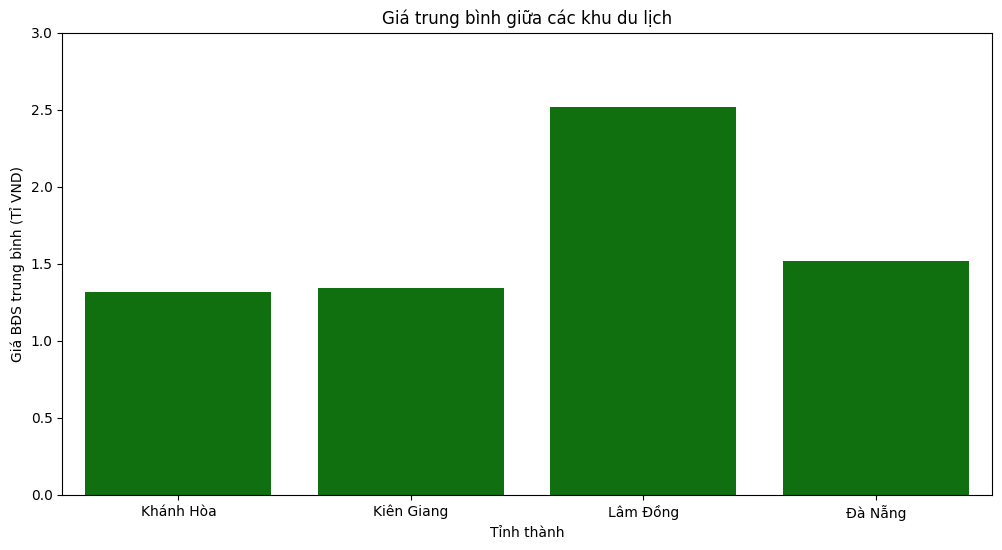

In [36]:
average_province = df_tourism.groupby('Province')['Price'].mean()

plt.figure(figsize=(12,6))
sns.barplot(x=average_province.index, y=average_province.values, color='Green')

yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{float(tick)/(10*(10**9)):,.1f}' for tick in yticks])

plt.title('Giá trung bình giữa các khu du lịch')
plt.xlabel('Tỉnh thành')
plt.ylabel('Giá BĐS trung bình (Tỉ VND)')


In [37]:
# 2. Box Plot: Hiển thị phân phối giá ở các vùng khác nhau.

''

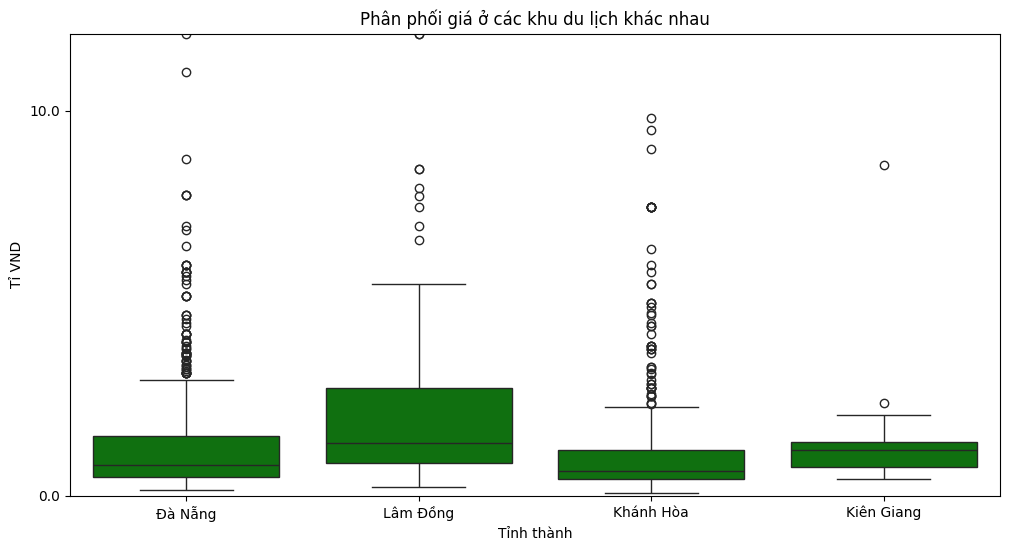

In [38]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Province', y='Price', data=df_tourism, color='Green')

yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{float(tick)/(10*(10**9)):,.1f}' for tick in yticks])
plt.ylim(0, 120000000000)

plt.title('Phân phối giá ở các khu du lịch khác nhau')
plt.xlabel('Tỉnh thành')
plt.ylabel('Tỉ VND')

;

In [39]:
#3. Violin Plot: Phân tích sự phân tán giá.

''

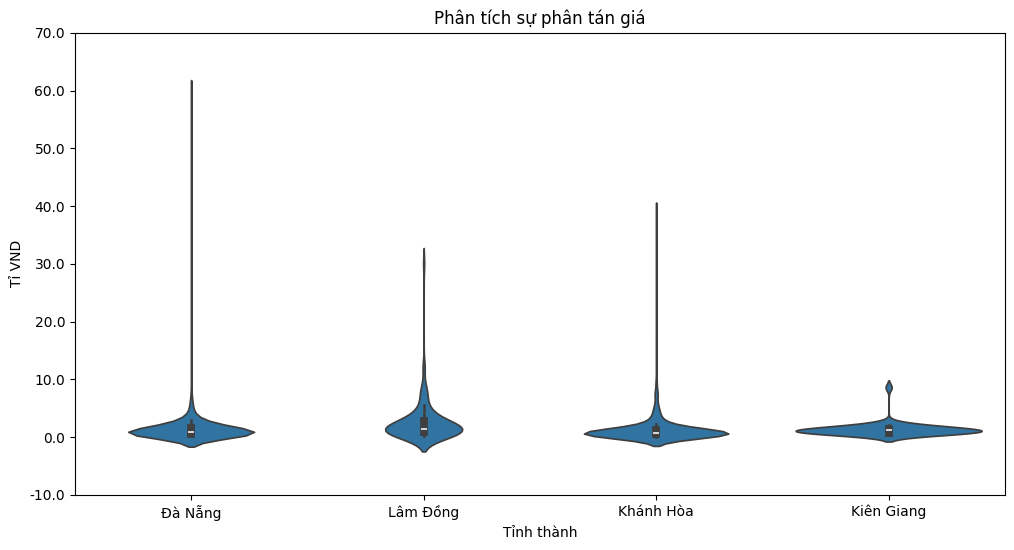

In [40]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='Province', y='Price', data=df_tourism)

yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{float(tick)/(10*(10**9)):,.1f}' for tick in yticks])

plt.title('Phân tích sự phân tán giá')
plt.xlabel('Tỉnh thành')
plt.ylabel('Tỉ VND')
;


In [41]:
# 4.Scatter Plot: Quan hệ giữa giá và số phòng ngủ.

''

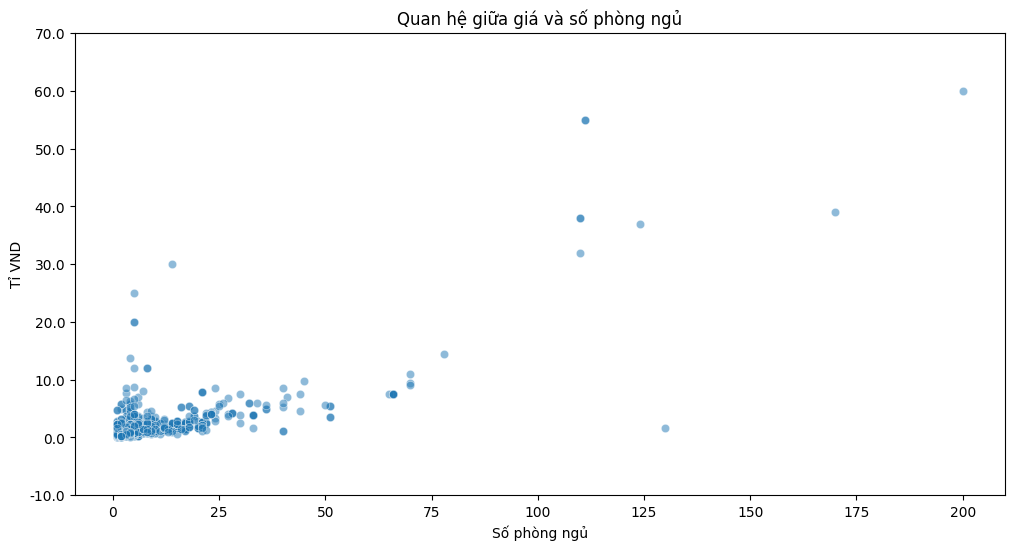

In [42]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='BedRoom', y='Price', data=df_tourism, alpha=0.5)

yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{float(tick)/(10*(10**9)):,.1f}' for tick in yticks])

plt.title('Quan hệ giữa giá và số phòng ngủ')
plt.xlabel('Số phòng ngủ')
plt.ylabel('Tỉ VND')
;

In [43]:
# 6.Pie Chart: Phân bố số lượng bất động sản theo khu vực.

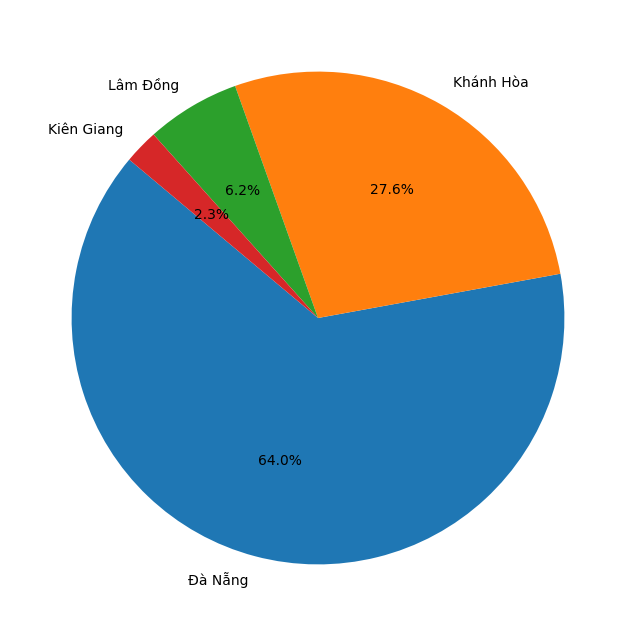

In [44]:
real_estate_counts = df_tourism['Province'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(real_estate_counts, labels=real_estate_counts.index, autopct='%1.1f%%', startangle=140);

In [45]:
# Histogram: Phân phối giá của bất động sản.

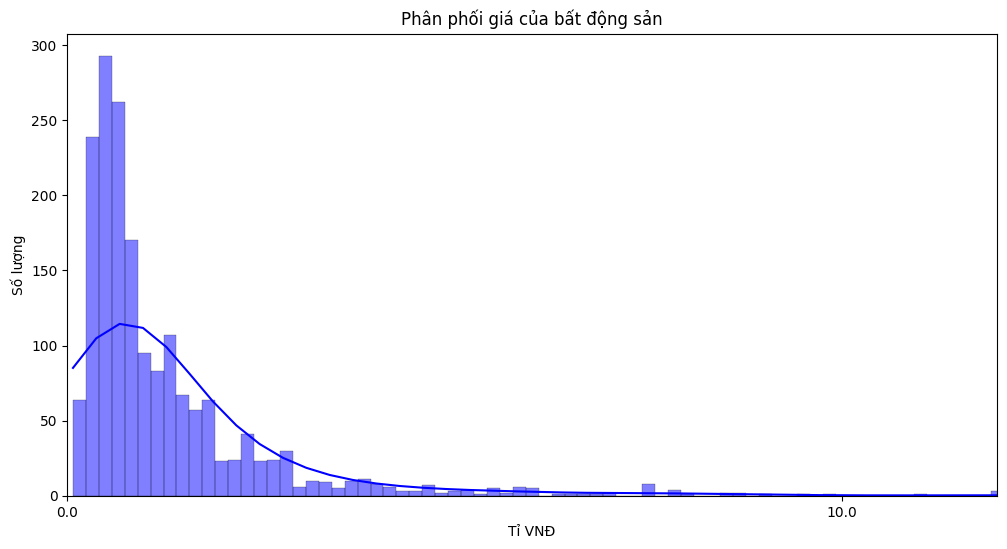

In [46]:
plt.figure(figsize=(12, 6))
sns.histplot(df_tourism['Price'], kde=True, color='blue')

xticks = plt.xticks()[0]
plt.xticks(xticks, labels=[f'{float(tick)/(10*(10**9)):,.1f}' for tick in xticks])
plt.xlim(0)
plt.xlim(0,120000000000)

plt.title('Phân phối giá của bất động sản')
plt.xlabel('Tỉ VNĐ')
plt.ylabel('Số lượng');

In [47]:
# Histogram: Phân phối tích lũy giá nhà

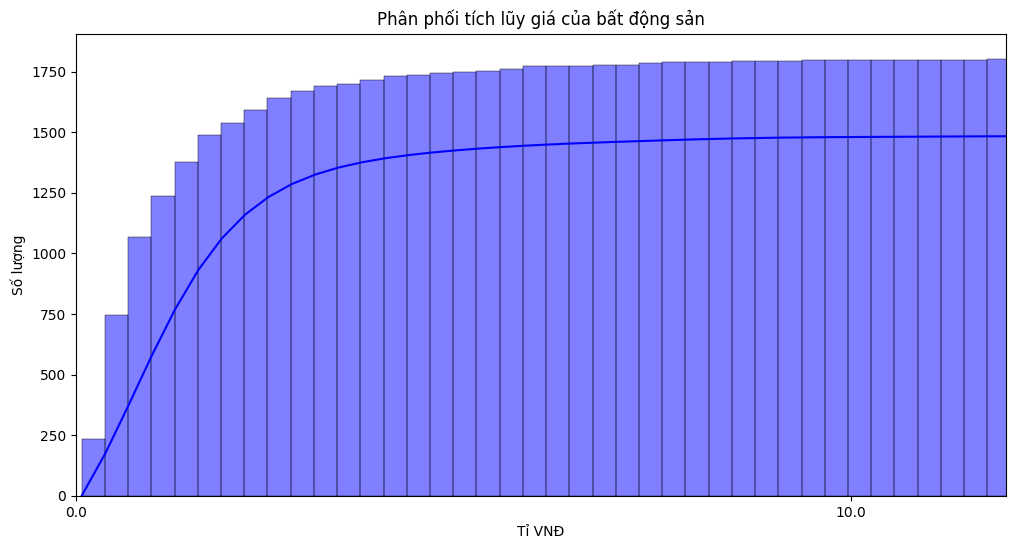

In [53]:
plt.figure(figsize=(12, 6))
sns.histplot(df_tourism['Price'], kde=True, color='blue', cumulative=True, bins=200)

xticks = plt.xticks()[0]
plt.xticks(xticks, labels=[f'{float(tick)/(10*(10**9)):,.1f}' for tick in xticks])
plt.xlim(0,120000000000)

plt.title('Phân phối tích lũy giá của bất động sản')
plt.xlabel('Tỉ VNĐ')
plt.ylabel('Số lượng');

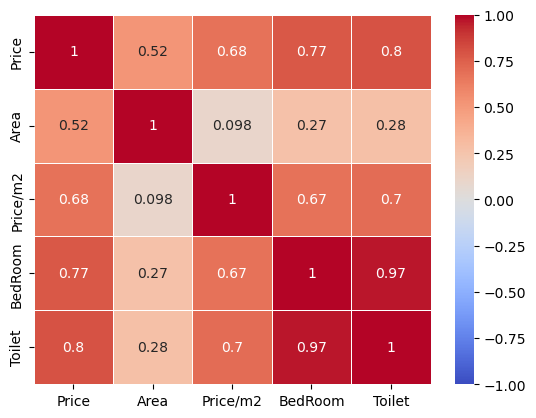

In [222]:
# Heatmap: Tương quan giữa giá và các yếu tố khác.
corr_matrix = df_tourism[['Price', 'Area', 'Price/m2', 'BedRoom', 'Toilet']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5);

In [223]:
# Pair Plot: Tương quan giữa các biến số khác nhau.

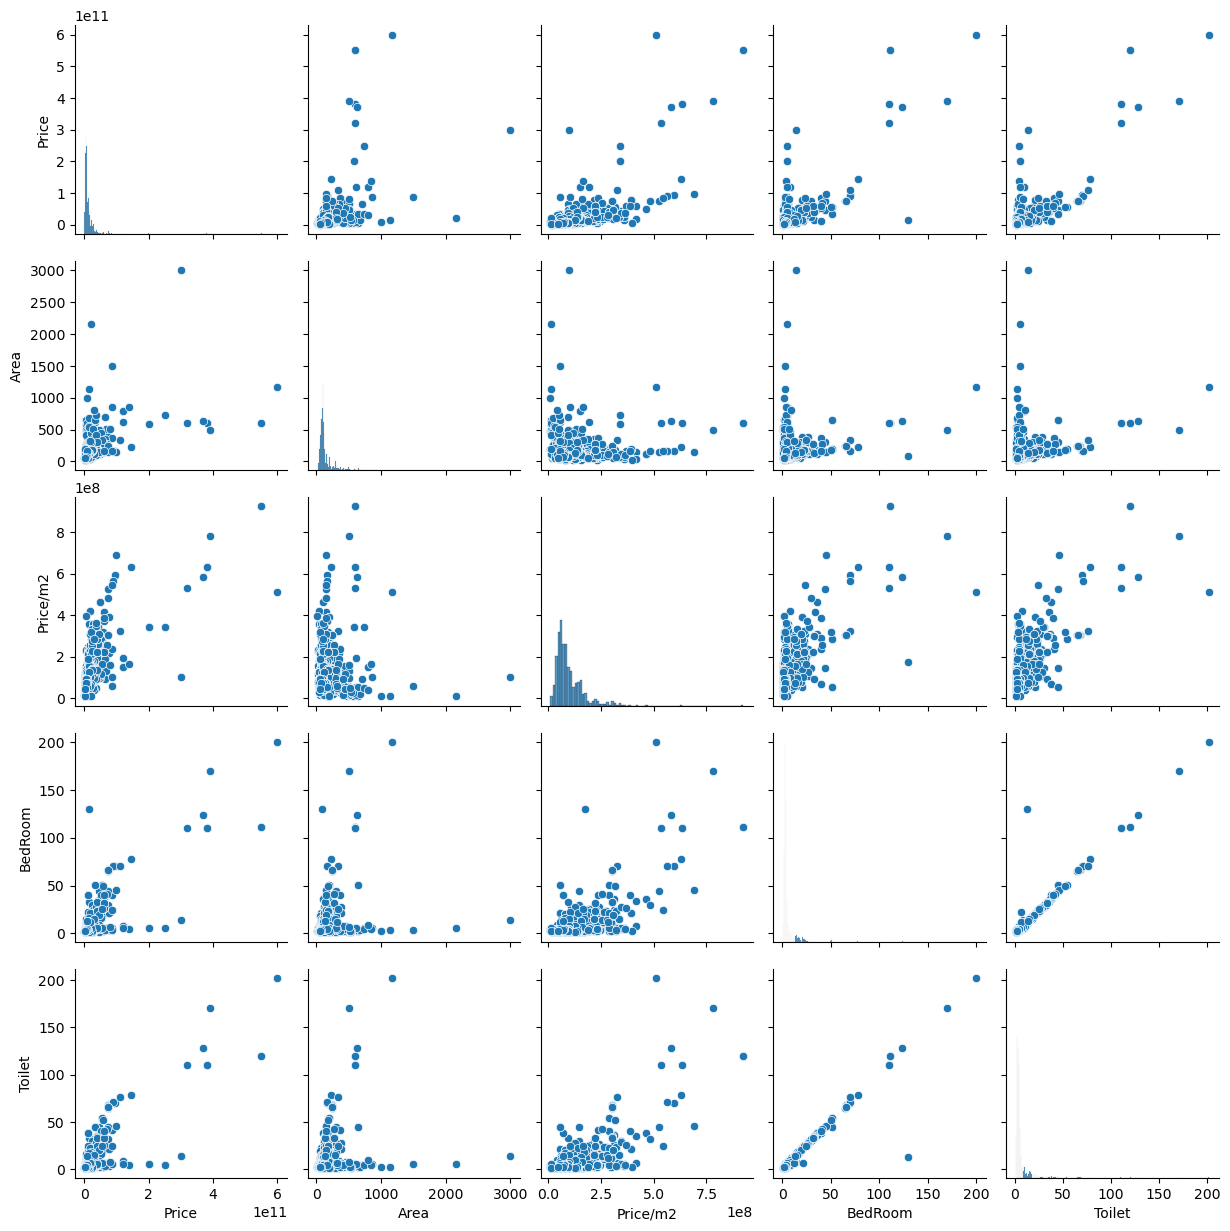

In [224]:
sns.pairplot(df_tourism[['Price', 'Area', 'Price/m2', 'BedRoom', 'Toilet']]);

In [225]:
# Density Plot

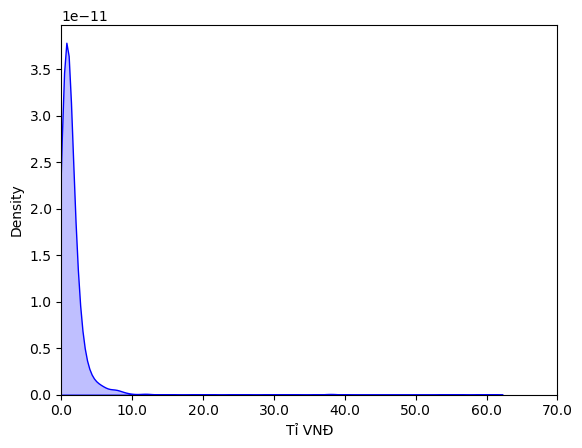

In [226]:
sns.kdeplot(df_tourism['Price'], color='blue', fill=True)

xticks = plt.xticks()[0]
plt.xticks(xticks, labels=[f'{float(tick)/(10*(10**9)):,.1f}' for tick in xticks])
plt.xlim(0)

plt.xlabel('Tỉ VNĐ');

In [227]:
# Area Plot: Hiển thị xu hướng giá.

''

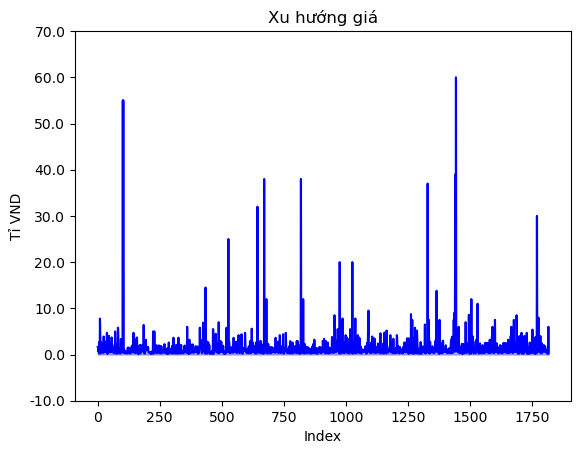

In [228]:
sns.lineplot(data=df_tourism['Price'], color='blue')
plt.fill_between(df_tourism.index, df_tourism['Price'], color='blue', alpha=0.3)

yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{float(tick)/(10*(10**9)):,.1f}' for tick in yticks])

plt.title('Xu hướng giá')
plt.xlabel('Index')
plt.ylabel('Tỉ VND')
;

In [229]:
# Biểu đồ bong bóng của giá bất động sản theo diện tích

''

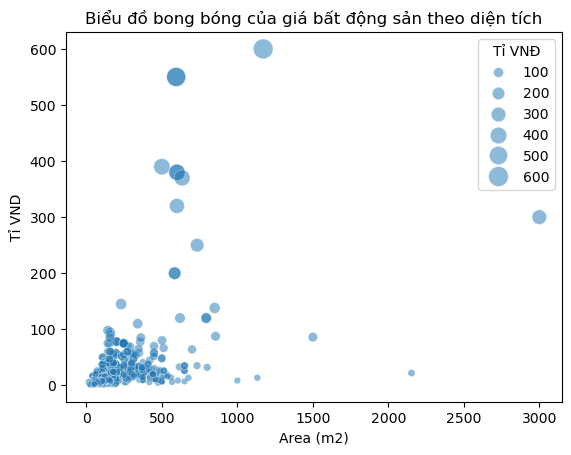

In [230]:
price_billion = df_tourism['Price'].apply(lambda x: x/(10**9))

sns.scatterplot(x=df_tourism.Area, y=price_billion, size=price_billion, sizes=(20, 200), alpha=0.5)

plt.title('Biểu đồ bong bóng của giá bất động sản theo diện tích')
plt.xlabel('Area (m2)')
plt.ylabel('Tỉ VND')

plt.legend(title='Tỉ VNĐ', fontsize='10')

;

In [232]:
# Huấn luyện mô hình
df_tourism['Province_encoded'] = LabelEncoder().fit_transform(df_tourism['Province'])
X = df_tourism[['Area', 'BedRoom', 'Toilet', 'Province_encoded']]
Y = df_tourism[['Price']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, Y_train)
price_predictions = model.predict(X_test)

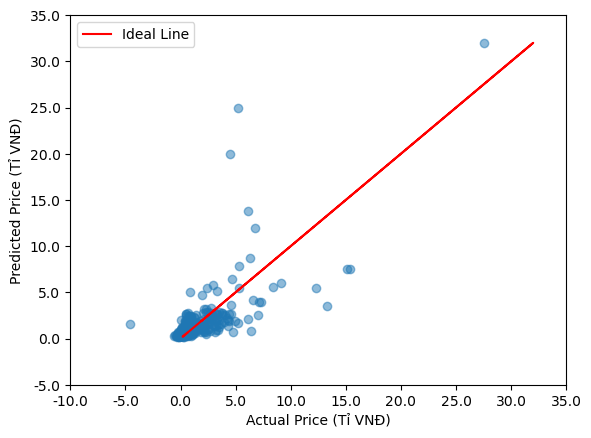

In [233]:
# Visualize khả năng dự đoán
plt.scatter(x=price_predictions, y=Y_test.values, alpha=0.5)
plt.plot(Y_test.values, Y_test.values, color='red', label='Ideal Line')

plt.ylabel('Predicted Price (Tỉ VNĐ)')
plt.xlabel('Actual Price (Tỉ VNĐ)')
plt.legend()

xticks = plt.xticks()[0]
plt.xticks(xticks, labels=[f'{float(tick)/(10*(10**9)):,.1f}' for tick in xticks])

yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{float(tick)/(10*(10**9)):,.1f}' for tick in yticks]);

In [234]:
# Đánh giá hiệu suất model

In [235]:
mse = mean_squared_error(Y_test, price_predictions)
mae = mean_absolute_error(Y_test, price_predictions)
r2 = r2_score(Y_test, price_predictions)
intercept = model.intercept_  
coefficients = model.coef_   

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² score: {r2}")
print(f"Intercept (β0 - Hằng số): {intercept}")
print(f"Hệ số hồi quy (β1, β2, β3,...): {coefficients}")

Mean Squared Error (MSE): 4.018070176611306e+20
Mean Absolute Error (MAE): 9352350380.81361
R² score: 0.4559286818385656
Intercept (β0 - Hằng số): [-1.05398667e+10]
Hệ số hồi quy (β1, β2, β3,...): [[ 6.92930164e+07 -6.25913057e+08  2.81189260e+09  1.24710886e+09]]
